# Задание 1
Реализуйте свой GAN или VAE(архитектура может быть похожа на архитектуру написанную на семинаре) на датасете, не входящем в перечень torchvision.
1.	Найдите набор данных состоящий минимум из 10 классов, укажите откуда был взят датасет (ссылку на набор данных или статью их описывающую).
https://www.kaggle.com/code/anuraggupta29/optical-character-recognition-chars74k-dataset/notebook
2.	Реализуйте GAN или VAE с обучением и инференсом.
3.	Выведите все классы вашего набора данных и все сгенерированные вашей сетью классы.
4.	Напишите вывод о ваших экспериментах с набором данных, архитектурой и ее параметрами


In [1]:
import torch
from torch import nn
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
# Скачиваем набор данных Chars74K
 #!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz

In [3]:
# Распаковываем архив с изображениями
#!tar -xvzf EnglishFnt.tgz

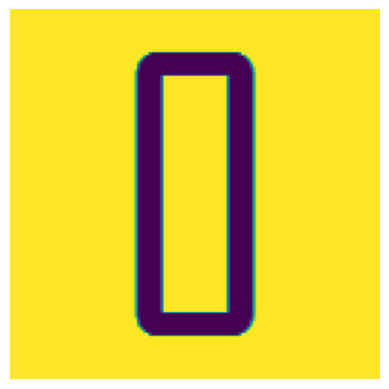

In [4]:
# Визуализация одного примера изображения из набора данных
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/English/Fnt/Sample001/img001-00001.png'  # Путь к одному изображению

try:
    # Загружаем изображение и отображаем его
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}. Check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

In [5]:
# Создаем собственный класс Dataset для работы с набором данных
class EnglishFntDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # Корневая папка с данными
        self.transform = transform  # Преобразования изображений
        self.image_paths = []  # Список путей к изображениям
        self.classes = []  # Список классов (меток)

        # С помощью рекурсии проходим папки и собираем пути к изображениям
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".png"):
                    self.image_paths.append(os.path.join(subdir, file))
                    # Имя класса определяется как имя подпапки
                    class_name = os.path.basename(os.path.dirname(os.path.join(subdir, file)))
                    self.classes.append(class_name)

    def __len__(self):
        return len(self.image_paths)  # Общее количество изображений

    def __getitem__(self, idx):
        # Загружаем изображение по индексу
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")  # Конвертируем в градации серого
        if self.transform:
            image = self.transform(image)  # Применяем преобразования
        return image

In [6]:
# Определяем преобразования для предобработки данных
transform = T.Compose([
    T.Resize((32, 32)),  # Изменяем размер изображения на 32x32 пикселя
    T.ToTensor(),  # Преобразуем в тензор
])

dataset = EnglishFntDataset('/content/English/Fnt', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
# Определение архитектуры VAE
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim  # Размерность латентного пространства

        # Энкодер: сверточные слои для извлечения признаков
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # Свертка, уменьшающая размер изображения вдвое
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # Еще одна свертка для сжатия
            nn.ReLU(),
            nn.Flatten()  # Преобразуем тензор в вектор
        )

        # Вычисляем размер выхода энкодера для определения входа линейных слоев
        dummy_input = torch.randn(1, 1, 32, 32)  # Создаем фиктивное изображение
        encoder_output_shape = self.encoder(dummy_input).shape
        linear_input_size = encoder_output_shape[1]  # Получаем размер после сверток

        # Линейные слои для параметров распределения
        self.fc_mu = nn.Linear(linear_input_size, latent_dim)  # Среднее (mu)
        self.fc_logvar = nn.Linear(linear_input_size, latent_dim)  # Логарифм дисперсии (logvar)

        # Декодер: обратное преобразование признаков в изображение
        self.decoder_input = nn.Linear(latent_dim, 64 * 8 * 8)  # Линейное преобразование латентного вектора
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 8, 8)),  # Преобразуем в тензор подходящего размера
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # Обратная свертка
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),  # Выходное изображение
            nn.Sigmoid()  # Активация для нормализации выходных значений
        )

    def encode(self, x):
        h = self.encoder(x)  # Пропускаем через энкодер
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)  # Вычисляем mu и logvar
        return mu, logvar

    def decode(self, z):
        z = self.decoder_input(z)  # Линейное преобразование латентного вектора
        return self.decoder(z)  # Обратное преобразование в изображение

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Вычисляем стандартное отклонение
        eps = torch.randn_like(std)  # Случайный шум
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)  # Кодируем изображение
        z = self.reparameterize(mu, logvar)  # Генерируем латентный вектор
        return self.decode(z), mu, logvar  # Возвращаем реконструкцию и параметры

In [8]:
# Определение функции потерь для VAE
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()

    def forward(self, recon_x, x, mu, logvar):
        # Реконструктивная ошибка
        recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_divergence  # Общая ошибка

In [9]:
# Инициализация устройства (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создаем модель VAE и оптимизатор
model = VAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = VAELoss()  # Функция потерь


In [10]:
# Цикл обучения
epochs = 55  # Количество эпох
for epoch in range(epochs):
    for data in tqdm(dataloader):
        data = data.to(device)
        optimizer.zero_grad()  # Обнуляем градиенты
        recon_batch, mu, logvar = model(data)  # Проход через модель
        loss = criterion(recon_batch, data, mu, logvar)  # Вычисляем функцию потерь
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновление параметров
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')  # Вывод

  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 1/55, Loss: 638.1903076171875


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 2/55, Loss: 601.5431518554688


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 3/55, Loss: 488.18621826171875


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 4/55, Loss: 597.3021850585938


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 5/55, Loss: 552.428466796875


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 6/55, Loss: 570.9083862304688


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 7/55, Loss: 567.8026733398438


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 8/55, Loss: 502.3999938964844


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 9/55, Loss: 482.8883972167969


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 10/55, Loss: 575.6890258789062


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 11/55, Loss: 551.680908203125


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 12/55, Loss: 627.2213134765625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 13/55, Loss: 542.5679321289062


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 14/55, Loss: 587.0455322265625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 15/55, Loss: 565.77099609375


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 16/55, Loss: 570.855712890625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 17/55, Loss: 504.42730712890625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 18/55, Loss: 573.67529296875


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 19/55, Loss: 511.1651916503906


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 20/55, Loss: 528.2271728515625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 21/55, Loss: 493.3450927734375


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 22/55, Loss: 548.1263427734375


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 23/55, Loss: 479.0522155761719


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 24/55, Loss: 607.4205322265625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 25/55, Loss: 546.7498779296875


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 26/55, Loss: 559.8157348632812


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 27/55, Loss: 490.07354736328125


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 28/55, Loss: 481.3756103515625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 29/55, Loss: 539.0675048828125


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 30/55, Loss: 481.381591796875


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 31/55, Loss: 578.3965454101562


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 32/55, Loss: 490.9111633300781


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 33/55, Loss: 517.298583984375


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 34/55, Loss: 554.436279296875


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 35/55, Loss: 571.4410400390625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 36/55, Loss: 490.2740478515625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 37/55, Loss: 604.6552124023438


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 38/55, Loss: 576.9878540039062


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 39/55, Loss: 516.9034423828125


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 40/55, Loss: 517.1171875


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 41/55, Loss: 515.0802001953125


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 42/55, Loss: 432.08746337890625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 43/55, Loss: 485.01177978515625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 44/55, Loss: 568.832275390625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 45/55, Loss: 467.0445556640625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 46/55, Loss: 492.0587463378906


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 47/55, Loss: 526.2864379882812


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 48/55, Loss: 467.3038330078125


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 49/55, Loss: 471.39208984375


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 50/55, Loss: 582.6405029296875


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 51/55, Loss: 507.8777770996094


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 52/55, Loss: 573.670166015625


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 53/55, Loss: 482.6501159667969


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 54/55, Loss: 527.4971923828125


  0%|          | 0/985 [00:00<?, ?it/s]

Epoch 55/55, Loss: 460.67791748046875


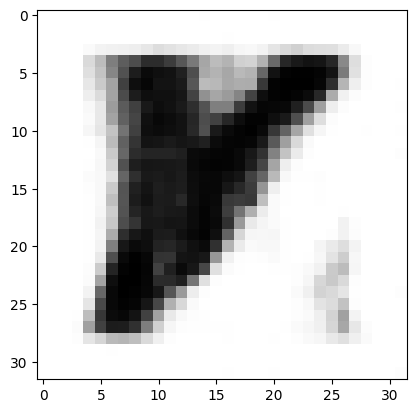

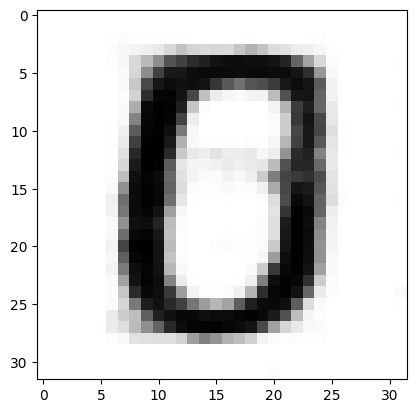

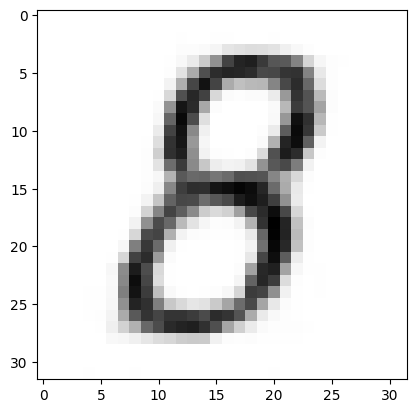

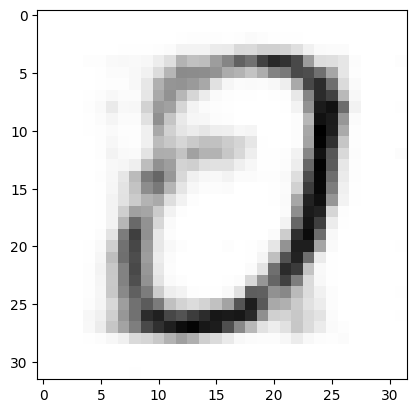

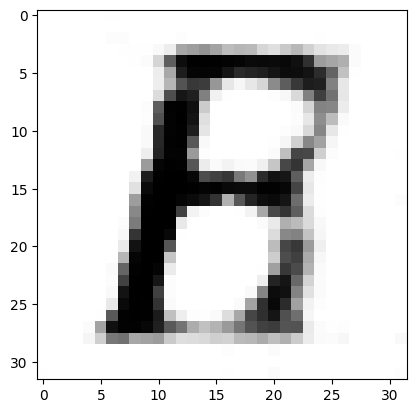

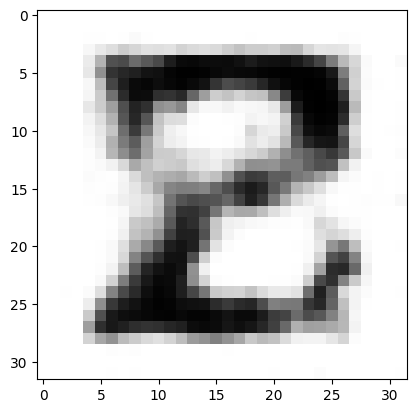

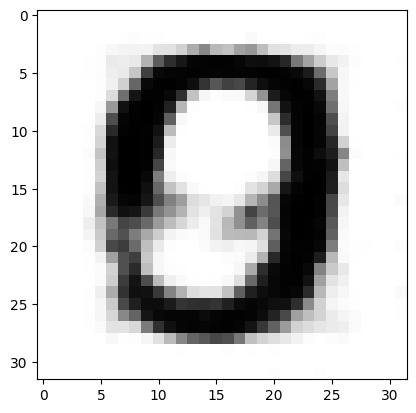

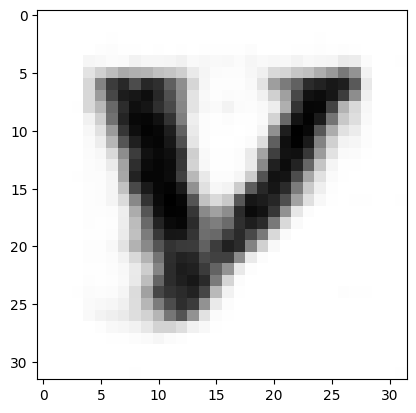

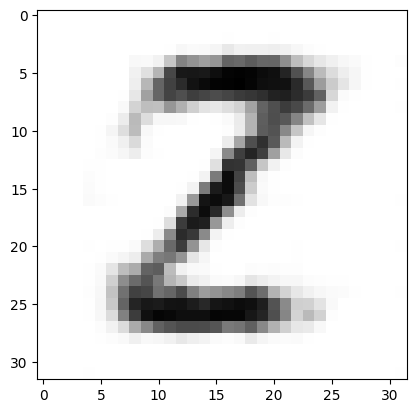

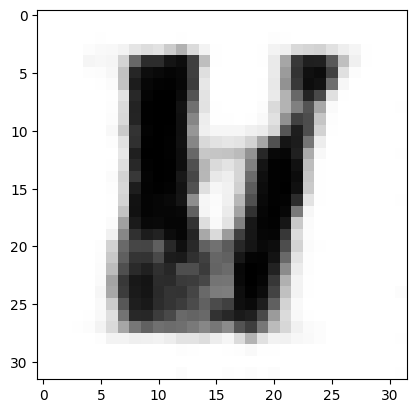

In [11]:
# Генерация новых изображений из случайных точек латентного пространства
with torch.no_grad():
    z = torch.randn(10, model.latent_dim).to(device)  # Генерируем случайный латентный вектор
    sample = model.decode(z)  # Пропускаем через декодер
    for i in range(10):
        plt.imshow(sample[i].cpu().squeeze(), cmap='gray')
        plt.show()


In [12]:
print("Классов в датасете:", len(set(dataset.classes)))

Классов в датасете: 62


# Эксперимент с VAE

В ходе эксперимента была реализована и протестирована вариационная автокодировочная сеть (VAE) для работы с набором данных Chars74K. Этот набор содержит изображения символов алфавита с различными шрифтами. Основная цель эксперимента заключалась в оценке способности VAE эффективно сжимать и реконструировать изображения символов, а также в исследовании генеративных возможностей модели.

# Архитектура и параметры модели

Энкодер:

1. Состоит из двух сверточных слоев с увеличением глубины фильтров (32 и 64).

2. Используется активационная функция ReLU.

Латентное пространство:

1. Размерность пространства задается параметром latent_dim=20 - который достаточно сжимает изображение сохраняя важную информацию.

Декодер:

1. Включает слой для преобразования латентного вектора обратно в тензор и два транспонированных сверточных слоя.

2. Используется активационная функция Sigmoid на выходе для получения значений в диапазоне [0, 1].

# Датасет и предобработка

Chars74K:

Поднабор изображений английских символов из папки English/Fnt. Каждый класс соответствует отдельному символу.

Изображения предварительно преобразуются в оттенки серого, масштабируются до размера 32×32 и нормализуются через ToTensor.

# Результаты

Генерация:

Использование случайных точек латентного пространства показало, что модель способна генерировать почти все (но при должном обучении все)  реалистичные изображения символов.

# Выводы

*   Данный эксперимент подтвердил эффективность применения VAE для задач генерации и реконструкции изображений символов.

*   Потенциальные улучшения включают экспериментирование с архитектурой (например, добавление слоев) и оптимизацию гиперпараметров (шаг обучения, latent_dim).

*   Возможно расширение эксперимента на другие наборы данных или усложнение входных изображений.





